In [ ]:
using Distributions
using PyCall
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Random
using SparseArrays
using JLD

include("src_balanced/param.jl");


# 1. Initial network consisting of strongly connected excitatory-inhibitory neurons

### Generate (static) recurrent connections of the balanced network.

* Synaptic weights follow the scaling rule: $w_{ij} \sim \frac{1}{\sqrt{K}}$ where $K$ is the average number of connections each neuron receives.

* Each neuron receives constant external input that follows the scaling rule: $\mu \sim \sqrt{K}.$

In [2]:
# Generate the (static) recurrent connections of a balanced network.
include("src_balanced/genWeights.jl")
w0Index, w0Weights, nc0 = genWeights(p);

### Simulate the activity of balanced network. 

In [3]:
# Simulate the neural activity of the balanced network
include("src_balanced/runinitial.jl")
times, ns0, uavg, synExc, synInh = runinitial(p, w0Index, w0Weights, nc0);


mean excitatory firing rate: 6.602 Hz
mean inhibitory firing rate: 11.974 Hz


Show strong recurrent excitatory and inhibitory synaptic inputs to neurons balancing each other.

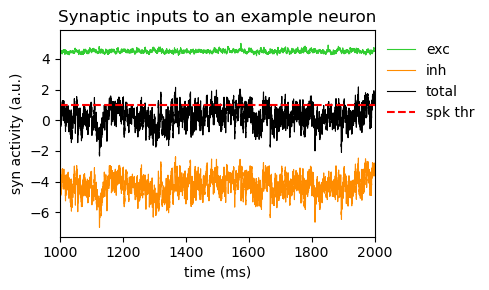

In [ ]:
# Plot the synaptic inputs to a neuron
timev = collect(p.dt:p.dt:p.train_duration)
figure(figsize=(5,3))
ci = 1
synNet = synExc[ci,:] .+ synInh[ci,:]
title("Synaptic inputs to a neuron")
plot(timev, synExc[ci,:], lw=0.8, c="limegreen", label="exc")
plot(timev, synInh[ci,:], lw=0.8, c="darkorange", label="inh")
plot(timev, synNet, lw=0.8, c="k", label="total")
axhline(1, color="r", linestyle="--", lw=1.5, label="spk thr")
xlim([1000,2000])
xlabel("time (ms)")
ylabel("syn activity (a.u.)")
legend(bbox_to_anchor=[1.0, 1.0], frameon=false)
tight_layout()
PyPlot.display_figs()

Show the spike times of neurons

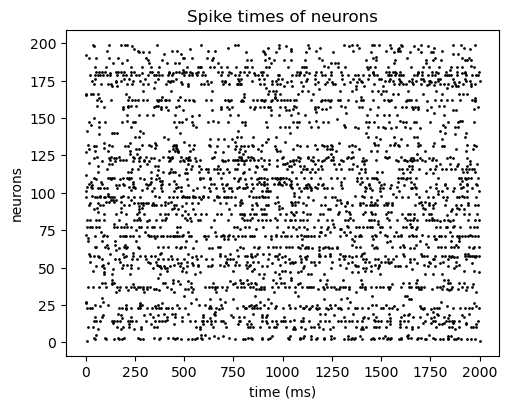

In [5]:
# Show spike times of a population of neurons
figure(figsize=(5,4))
title("Spike times of neurons")
for i = 1:200
    plot(times[i,1:ns0[i]], i*ones(ns0[i]), marker=".", ms=4, mec="None", c="k", linestyle="")
end
tight_layout()
xlabel("time (ms)")
ylabel("neurons")
PyPlot.display_figs()

# 2. Set up to train a subset of neurons to generate target activity patterns

### (a) Target activity patterns: ALM neurons firing rates

In [6]:
# select cells to be trained
rtarg_lickright = load("src_balanced/data_alm/movingrate_Pyr1Hz_lickright.jld", "Pyr");
rtarg_lickleft = load("src_balanced/data_alm/movingrate_Pyr1Hz_lickleft.jld", "Pyr");

# load targets
xtarg = Vector{Array{Float64,2}}()
utarg_R = transpose(load("src_balanced/data_alm/utarg1Hz_lickright.jld", "utarg"));
utarg_L = transpose(load("src_balanced/data_alm/utarg1Hz_lickleft.jld", "utarg"));
push!(xtarg, utarg_R)
push!(xtarg, utarg_L)


2-element Vector{Matrix{Float64}}:
 [0.4664474015023653 0.6903938354681215 … 0.43255977719137234 0.4857814661985362; 0.4664474015023653 0.6940612389406814 … 0.4352288752579819 0.48255675647171997; … ; 0.7219274931201025 0.5541068868013189 … 0.4486910236779185 0.39362755953764866; 0.7138064463180421 0.5571330465603646 … 0.4478845055349037 0.3836241871398783]
 [0.3415834235790131 0.6592665665390282 … 0.4149732642575865 0.47680257633508355; 0.3446962999605829 0.6570707720616271 … 0.42340329336439814 0.47680257633508355; … ; 0.51142249836683 0.6848457657887894 … 0.44897054537502445 0.4226406845122062; 0.5150728247543089 0.6925810371392006 … 0.45378089701936514 0.41420020761132864]

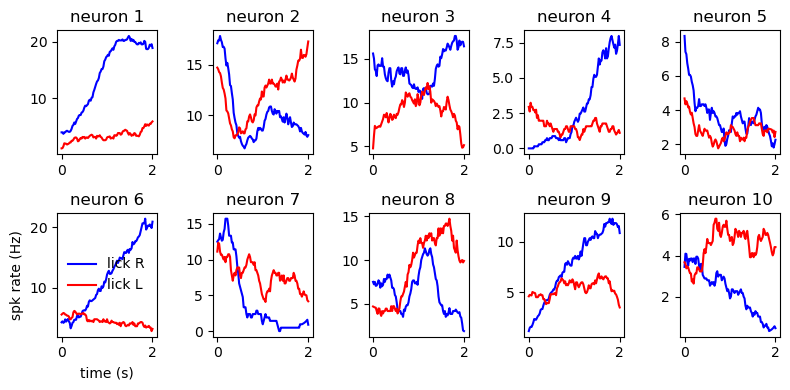

In [7]:
# Plot the activity patterns of ALM Pyramidal neurons
tvec = 0.02 * collect(0:100)
figure(figsize=(8,4))
for ci = 1:10
    subplot(2,5,ci)
    title("neuron $(ci)")
    plot(tvec, rtarg_lickright[ci,:], c="b", label="lick R")
    plot(tvec, rtarg_lickleft[ci,:], c="r", label="lick L")
    if ci == 6
        xlabel("time (s)")
        ylabel("spk rate (Hz)")
        legend(frameon=false, fontsize=10)
    end
end
tight_layout()
PyPlot.display_figs()

### (b) Stimulus to trigger target activity patterns

In [ ]:
# Generate stimulus to trigger response.
include("src_balanced/genStim.jl")

stim = Vector{Array{Float64,2}}()
for lick = 1:2
    stim_val = genStim(p)
    push!(stim, stim_val);
end

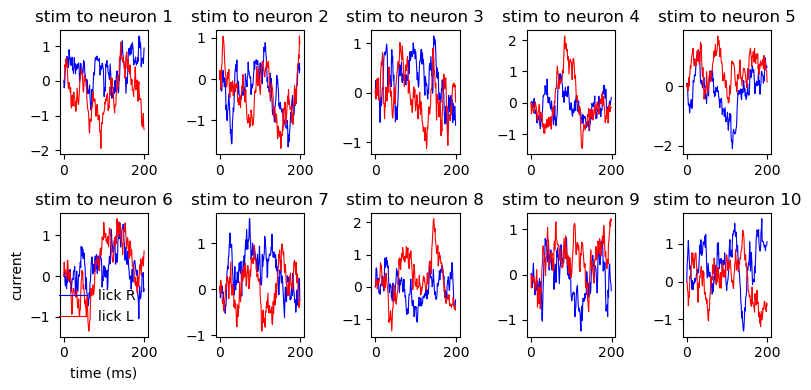

In [13]:
figure(figsize=(8,4))
for ci = 1:10
    subplot(2,5,ci)
    title("stim to neuron $(ci)")
    plot(stim[1][1:10:end,ci], c="b", label="lick R", lw=0.8)
    plot(stim[2][1:10:end,ci], c="r", label="lick L", lw=0.8)
    if ci == 6
        xlabel("time (ms)")
        ylabel("current")
        legend(frameon=false)
    end
end
tight_layout()
PyPlot.display_figs()

### (c) Select a subset of neurons to train

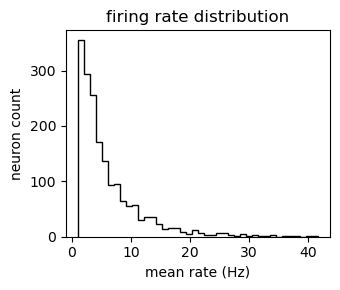

In [ ]:
# firing rate distribution
figure(figsize=(3.5,3))
title("firing rate distribution of ALM neurons")
mean_rate = mean(rtarg_lickright,dims=2)[:]
hist(mean_rate, bins=40, histtype="step", color="k")
xlabel("mean rate (Hz)")
ylabel("neuron count")
tight_layout()
PyPlot.display_figs()

Match the mean firing rates of ALM neurons and model neurons

In [9]:
include("src_balanced/genCellsTrained.jl")
# sample a subset of neurons to be trained
Npyr = size(rtarg_lickleft,1) # Npyr = 1824
Ntrained = Npyr 
rtarg_mean = (rtarg_lickright + rtarg_lickleft)/2;
almOrd, matchedCells = genCellsTrained(rtarg_mean, ns0);


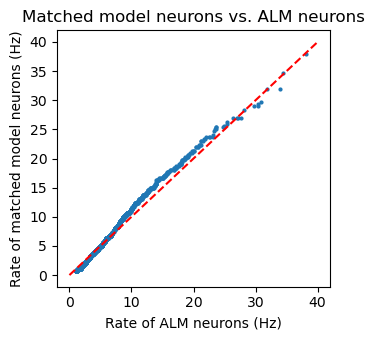

In [10]:
alm_mean_rate = mean(rtarg_mean,dims=2)[almOrd]
model_mean_rate = ns0[matchedCells] / (p.train_time/ 1000)
idline = collect(0:40)
figure(figsize=(3.5,3.5))
title("Matched model neurons vs. ALM neurons")
plot(alm_mean_rate, model_mean_rate, marker="o", ms=2, linestyle="")
plot(idline, idline, c="r", linestyle="--")
xlabel("Rate of ALM neurons (Hz)")
ylabel("Rate of matched model neurons (Hz)")
tight_layout()
PyPlot.display_figs()


### (d) Initialize sparse plastic synapses to train

NEED FURTHER EXPLANATION

In [11]:
# Generate plastic connections to be trained
include("src_balanced/genPlasticWeights.jl")
include("src_balanced/convertWgtIn2Out.jl")
wpWeightFfwd, wpWeightIn, wpWeightOut, 
wpIndexIn, wpIndexOut, wpIndexConvert, 
ncpIn, ncpOut = genPlasticWeights(p, w0Index, nc0, ns0, matchedCells);


### Initialize plastic feedforward conections to neurons (optional)

In [16]:
# generate feedforward drive
include("src_balanced/genffwdRate.jl")
include("src_balanced/funMovAvg.jl")

ffwdRate_mean = 5.0; # Hz
ffwdRate = Vector{Array{Float64,2}}();
for lick = 1:2
    ffwdRate_val = genffwdRate(p, ffwdRate_mean);
    push!(ffwdRate, ffwdRate_val);
end

## 3 Train a subset of neurons in the balanced network

Train a subset of neurons to follow target activity patterns

In [ ]:
#train spatial model
using Statistics
p.nloop=50
p.refrac=0.1

include("src_balanced/runtrain.jl")
include("src_balanced/runperformance.jl")
include("src_balanced/runtest.jl")
include("src_balanced/funRollingAvg.jl")

#define path to data network 

dirNetwork = "src_balanced/data_network/"
mkpath(dirNetwork)

wpWeightIn, wpWeightOut, wpWeightFfwd = runtrain(dirNetwork,p,w0Index,w0Weights,nc0, stim, xtarg,
wpWeightFfwd, wpIndexIn, wpIndexOut, wpIndexConvert, wpWeightIn, wpWeightOut, ncpIn, ncpOut,
almOrd, matchedCells, ffwdRate)


Loop no. 1
elapsed time: 43.05780792236328
Loop no. 2
elapsed time: 

Show training performance

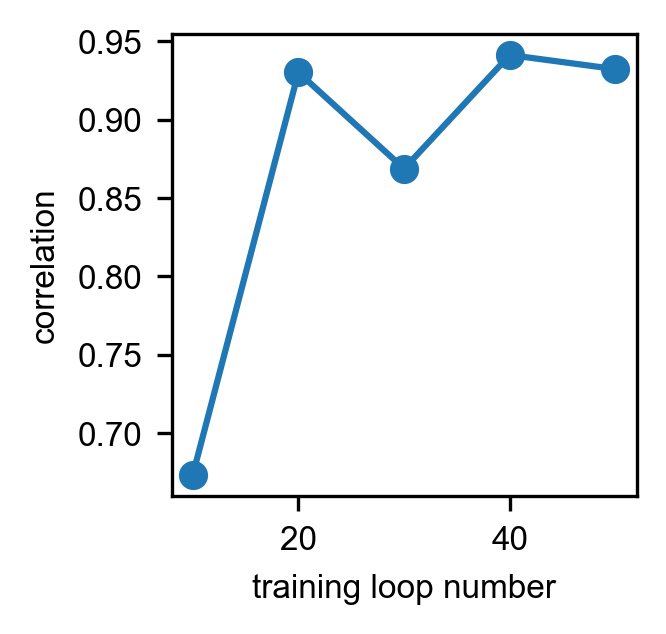

In [27]:
#Check correlation between xtarg and xtotal

iloop=50

loop_numbers = range(10, stop=iloop, step=10)
corr_vals=Float64[]

for l in 10:10:iloop
    filename = dirNetwork * "_performance_R_loop$(l).txt"
    corr = [parse(Float64, item) for item in readlines(filename)][1]
    push!(corr_vals, corr)
end
figure(figsize=(2,2))
plot(loop_numbers, corr_vals,"-o")
ylabel("correlation")
xlabel("training loop number")
PyPlot.display_figs()

## 4 Show the activity of trained neurons

Show that trained neurons' activity follow the target activity patterns

In [28]:
iloop=50
xtotal = load(dirNetwork * "xtotal_$(iloop).jld")["xtotal"]
xebal = load(dirNetwork * "xebal_$(iloop).jld")["xebal"]
xibal = load(dirNetwork * "xibal_$(iloop).jld")["xibal"]
xplastic = load(dirNetwork * "xplastic_$(iloop).jld")["xplastic"]
times = load(dirNetwork * "times_$(iloop).jld")["times"]
ns = load(dirNetwork * "ns_$(iloop).jld")["ns"];

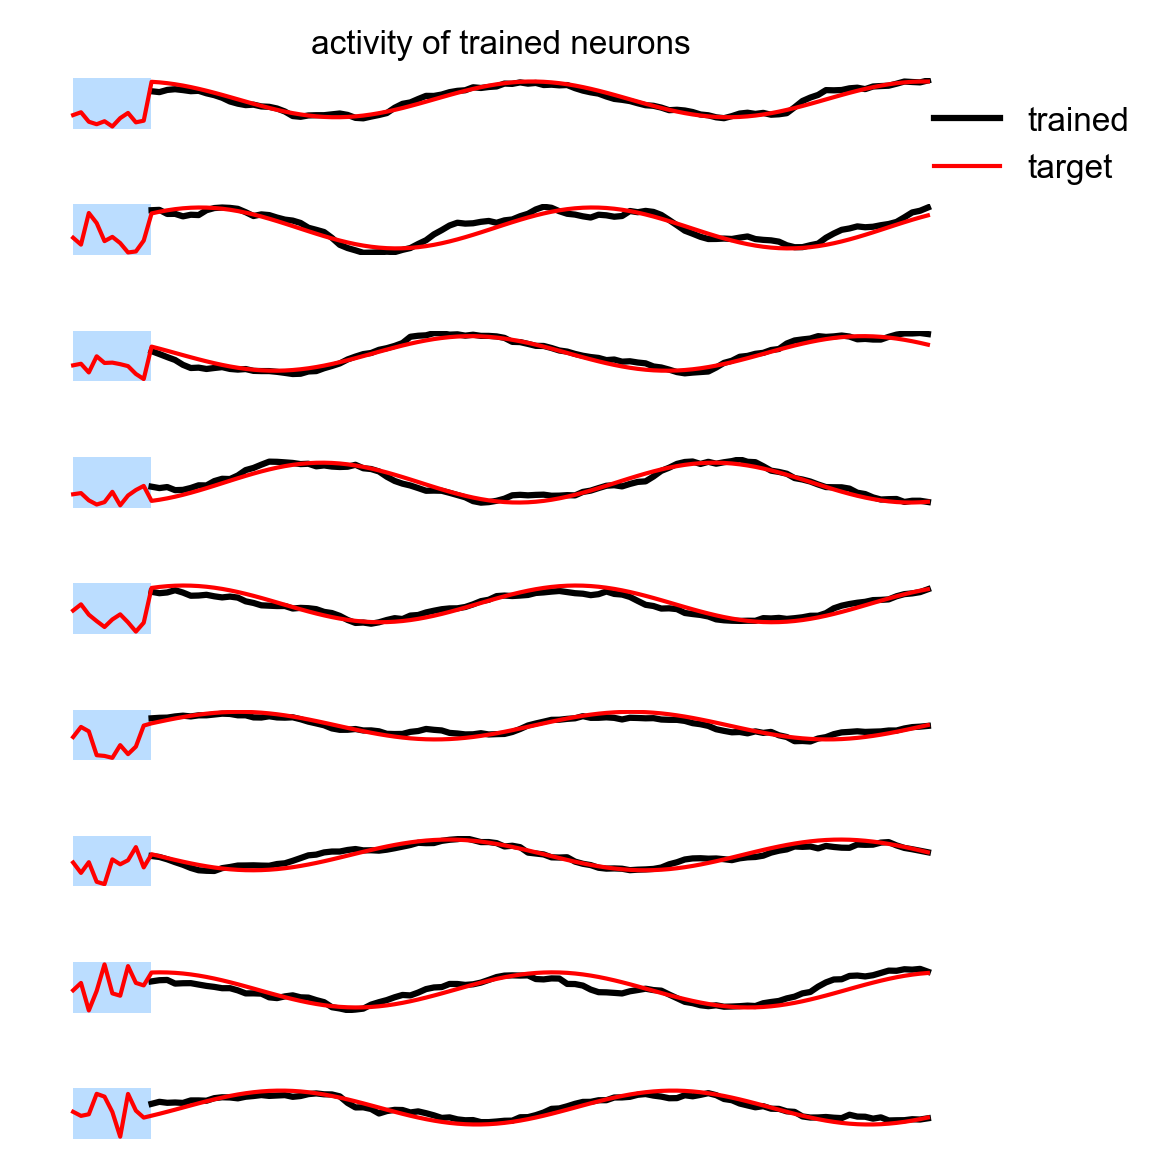

[10010.0, 10210.0, 10410.0, 10610.0, 10810.0, 11010.0, 11210.0, 11410.0, 11610.0, 11810.0, 12010.0, 12210.0, 12410.0, 12610.0, 12810.0, 13010.0, 13210.0, 13410.0, 13610.0, 13810.0, 14010.0, 14210.0, 14410.0, 14610.0, 14810.0, 15010.0, 15210.0, 15410.0, 15610.0, 15810.0, 16010.0, 16210.0, 16410.0, 16610.0, 16810.0, 17010.0, 17210.0, 17410.0, 17610.0, 17810.0, 18010.0, 18210.0, 18410.0, 18610.0, 18810.0, 19010.0, 19210.0, 19410.0, 19610.0, 19810.0, 20010.0, 20210.0, 20410.0, 20610.0, 20810.0, 21010.0, 21210.0, 21410.0, 21610.0, 21810.0, 22010.0, 22210.0, 22410.0, 22610.0, 22810.0, 23010.0, 23210.0, 23410.0, 23610.0, 23810.0, 24010.0, 24210.0, 24410.0, 24610.0, 24810.0, 25010.0, 25210.0, 25410.0, 25610.0, 25810.0, 26010.0, 26210.0, 26410.0, 26610.0, 26810.0, 27010.0, 27210.0, 27410.0, 27610.0, 27810.0, 28010.0, 28210.0, 28410.0, 28610.0, 28810.0, 29010.0, 29210.0, 29410.0, 29610.0, 29810.0]

In [31]:
# compare synaptic activity and its target activity
tvec = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt)
ttarg = collect((p.stim_on+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt) #.+ 2000.0
print(tvec)

figure(figsize=(4,4))
for ci = 1:9
    subplot(9,1,ci)
    axvspan(p.stim_on/p.dt, p.stim_off/p.dt, color="dodgerblue", alpha=0.3, ec="None")
    plot(tvec, xtotal[:,ci].+p.muemax, c="k", label = "trained")
    plot(ttarg, vcat(stim[1][1:Int(p.learn_every/p.dt):end,ci], xtarg[1][:,ci]), c="r", lw=1, label="target")
    annotate("neuron$(ci)", ((p.stim_on/p.dt)-1000,5), fontsize=8)
    
    if ci ==1
        title("activity of trained neurons")
        legend(frameon=false, bbox_to_anchor=(1.2, 1.05),loc="upper right")
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()

In [32]:
#Get spike rates for each cell in the network 
include("src_balanced/spk2rate.jl")
spikes = spk2rate(p, matchedCells, times, ns);

for ci in matchedCells
    figure()
    plot(spikes[:,ci])
    xlabel("time")
    ylabel("firing rate (spk/s)")

ErrorException: syntax: incomplete: "for" at /Users/kimchm/Documents/GitHub/TutorialCNS2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sZmlsZQ==.jl:5 requires end

## 2.3 Show the activity of untrained neurons